# Feature selection

## Recursive Feature Elimination

- feature 중요도가 낮은 속성들을 차례로 제거해 가면서 반복적으로 학습/평가를 수행해 최적의 feature 도출
- 하지만 수행시간이 오래걸리면 본질적으로 모든 조합을 하지 않기 때문에 정확한 Feature selection은 불가

Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.


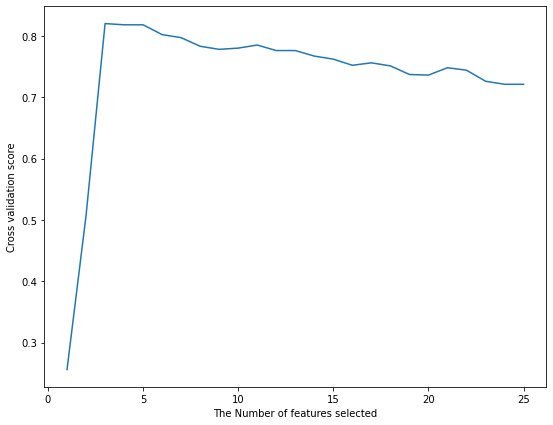

In [4]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFE, RFECV
from sklearn.datasets import make_classification

#분류를 위한 전용 임의의 데이터 생성
X, y = make_classification(n_samples=1000, n_features=25,
                          n_informative=3, n_repeated=0,
                          n_classes=8, n_clusters_per_class=1,
                          random_state=0)
svc = SVC(kernel='linear')
# RFE + CV(교차검증)으로 feature selection 적용
# step: 몇개의 feature만큼 제거하면서 반복할지
# verbose=2 : 하이퍼파라미터별 메세지까지 출력
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(2),
             scoring='accuracy', verbose=2)
# Feature를 하나씩 제거하면서 학습/평가를 계속적으로 반복
rfecv.fit(X, y)

# 몇 개의 feature를 갖고 학습/평가했는지 출력
print(f"Train & Test with {rfecv.n_features_}")

# feature 개수에 따른 성능 그래프 시각화
plt.figure(figsize=(9,7))
plt.plot(range(1, len(rfecv.grid_scores_)+1),rfecv.grid_scores_)
plt.xlabel('The Number of features selected')
plt.ylabel('Cross validation score')
plt.show()

## SelectFromModel

- 특정 임곗값을 설정해 그 기준보다 높은 feature들만 selection

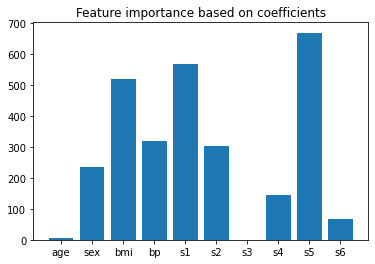

In [7]:
import numpy as np
from sklearn.datasets import load_diabetes
from sklearn.linear_model import LassoCV
import matplotlib.pyplot as plt

diabetes = load_diabetes()
X, y = diabetes.data, diabetes.target

# L1 norm 규제를 사용한 Lasso 사용(Lasso는 람다값을 0으로 만들어 Feature selection 기능도있음)
# CV도 적용
lasso = LassoCV().fit(X, y)
# Lasso 회귀에서 feature importance는 회귀계수(coefficient)인 셈
importance = np.abs(lasso.coef_)
feature_names = np.array(diabetes.feature_names)
plt.bar(height=importance, x=feature_names)
plt.title("Feature importance based on coefficients")
plt.show()

In [14]:
# SelectFromModel로 임계치 설정해 Feature Selection
from sklearn.feature_selection import SelectFromModel
from time import time

# 위에서 구한 feature별 회귀계수 중 상위 3번째 값에서 0.01을 더한 값을 임계치로 설정
threshold = np.sort(importance)[-3] + 0.01

# threshold 인자에 string형태로 median, mean 넣을 수 있음.
# 만약 median에 2를 곱한 값을 임계치로 넣고 싶다면 "2 * median"으로 str형태로 넣어주면 됨
sfm = SelectFromModel(lasso, threshold=threshold).fit(X, y)

# 임계치보다 높은 feature 출력
# boolean index 형태로 True값만 가져오기(sfm.get_support()는 boolean값으로 출력됨)
print("Features selected by SelectFromModel: ",
     feature_names[sfm.get_support()])

Features selected by SelectFromModel:  ['s1' 's5']


## Permutation Importance

- 특정 feature의 값을 사용자가 정의한 횟수만큼 반복적으로 shuffle을 해서 테스트 데이터에만 적용하여 평가 성능을 도출. 그리고 평균값을 냄
- 위 과정을 모든 feature의 값들을 수행해서 가장 성능을 저하시키는 feature를 중요 feature로 selection

In [15]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score

diabetes = load_diabetes()
X_train, X_val, y_train, y_val = train_test_split(diabetes.data, diabetes.target, random_state=0)

#학습, 예측, R2 Score 평가 
model = Ridge(alpha=1e-2).fit(X_train, y_train)
y_pred = model.predict(X_val)
print('r2 score:', r2_score(y_val, y_pred))

r2 score: 0.35666062386954545


In [16]:
from sklearn.inspection import permutation_importance

# 인자에 모델, 평가 데이터, 반복횟수, 시드 넣어주기
r = permutation_importance(model, X_val, y_val, n_repeats=30, random_state=0)

# 위에서 계산한 feature별 중요도 기준으로 상위 feature 도출
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(diabetes.feature_names[i],"   ", np.round(r.importances_mean[i], 4), " +/- ", np.round(r.importances_std[i], 5))

s5     0.2042  +/-  0.04965
bmi     0.1758  +/-  0.0484
bp     0.0884  +/-  0.03284
sex     0.0559  +/-  0.02319


## Permutation Importance VS Feature Importance based on Random Forest

## Feature Importance based on Random Forest

In [17]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

In [22]:
# titanic 데이터 세트 로딩. 
X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)

rng = np.random.RandomState(seed=42)

## 두 방법 비교를 위해서 임의적으로 랜덤값으로 이루어진 변수 추가
# 3가지 값으로 category값 random 설정. 
    # 0부터 2까지 size만큼 난수 생성
X['random_cat'] = rng.randint(3, size=X.shape[0])
# X건수만큼 고유한 random 값 설정. 
X['random_num'] = rng.randn(X.shape[0])

categorical_columns = ['pclass', 'sex', 'embarked', 'random_cat']
numerical_columns = ['age', 'sibsp', 'parch', 'fare', 'random_num']

X = X[categorical_columns + numerical_columns]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42)

# Pipeline과 ColumnTransformer을 이용해 전처리, 모델링 한 프로세스로 만들기
categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))#범주형 값으로 모르는 값이 있을 때 에러메세지 무시
])
numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

# 위에서 정의해준 pipeline들로 한 번에 전처리하도록 ColumnTransformer 정의
# ColumnTransformer([('Transformer_명',pipeline, 변형시킬 칼럼들_list]))
preprocessing = ColumnTransformer([
    ('cat', categorical_pipe, categorical_columns),
    ('num', numerical_pipe, numerical_columns)
])

# 미지막으로 위에서 전처리하는 프로세스와 모델링을 한 Pipeline에 담기
rf = Pipeline([
    ('preprocess', preprocessing),
    ('model', RandomForestClassifier(random_state=42))
])
# 학습
rf.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['pclass', 'sex', 'embarked',
                                                   'random_cat']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['age', 'sibsp', 'par

/Users/younghun/opt/anaconda3/envs/venvforpython/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator


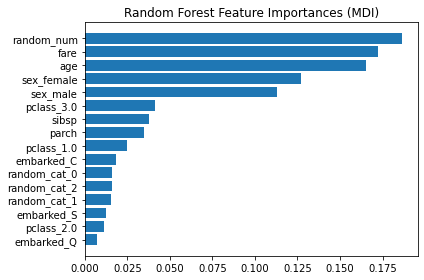

In [49]:
# rf.named_steps로 위에서 만들어준 Pipeline 모든 흐름 볼 수 있음
# 이를 이용해 원하는 단계의 인코딩이나 모델 추출 가능
ohe = (rf.named_steps['preprocess']
         .named_transformers_['cat']
         .named_steps['onehot'])
# input_features인자로 feature에 맞는 변수이름 지정
feature_names = ohe.get_feature_names(input_features=categorical_columns)
# np.r_ 은 numpy array를 concatenate하는 다른 방식! 
feature_names = np.r_[feature_names, numerical_columns]

# 학습시킨 Random Forest 모델의 Feature 중요도 추출
tree_feature_importances = (
    rf.named_steps['model'].feature_importances_)
sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots()
# y_ticks값들 각각에 feature 중요도 상위 순서로 표시
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
# y_ticks 이름 feature name으로 대체
ax.set_yticklabels(feature_names[sorted_idx])
# y축을 위에서 대체한 값으로 setting 다시 해주어야 함!
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.show()

## Permutation Importance

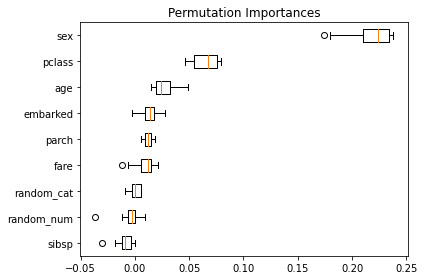

In [58]:
result = permutation_importance(rf, X_test, y_test, n_repeats=10,
                               random_state=42)
# feature 중요도 순서 내림차순으로 정렬한 값들의 index 반환
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
# result.importances[sorted_idx].shape는 (9,10)
# 행은 feature 개수, 열은 위에서 중요도 계산시 반복 횟수
# 그래프 보기좋게 그리기 위해 Transpose하기, vert:vertical 그래프
ax.boxplot(result.importances[sorted_idx].T,
          vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances")
# subplot 그래프 여백 조절
fig.tight_layout()
plt.show()

---
- np.r_ 예시

In [31]:
a = np.array([[1,2,3],
             [4,5,6]])
b = np.array([[7,8,9],
             [10,11,12]])
np.r_[a, b]

array([[ 1,  2,  3],
       [ 4,  5,  6],
       [ 7,  8,  9],
       [10, 11, 12]])